## Synchronizing the Tile Data with A50 Ground Truth

All signals will be within 30 seconds worst case scenario. The goal is to use ground truth data to inform the inertial signals from the tile- although, the tile data alone will provide enough analysis in the interim.

> Note: The tile data is coming in at 100Hz!

Synch ideas:

- could use the altitude data to get that first timestamp
  - ground truth signals don't really agree on this
  - will have to convert from pressure data to elevation as well

In [1]:
from track import Track
from decode import decode_A50, decode_A50_downhill, decode_F6P, decode_tile
import pandas as pd
import matplotlib.pyplot as plt

a50 = decode_A50_downhill("../DATA/2023_12_31/Mt St Sauveur/A50/Mount St Sauveur PATCHED.csv")
a50_all = decode_A50("../DATA/2023_12_31/Mt St Sauveur/A50/Mount St Sauveur PATCHED.csv")
f6p = decode_F6P("../DATA/2023_12_31/Mt St Sauveur/F6P/13306856415_ACTIVITY.csv")
tile = decode_tile("../DATA/2023_12_31/Mt St Sauveur/Tile/SENS000.CSV")

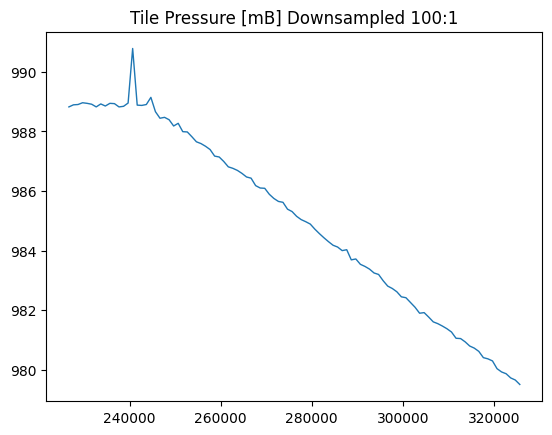

In [2]:
plt.rc('lines', linewidth=1)
fig, ax = plt.subplots()
ax.plot(tile.time[20000:30000:100], tile.pres[20000:30000:100])
ax.set_title('Tile Pressure [mB] Downsampled 100:1')
plt.show()

### Horizontal Time Offsets 

Align it with the elevation data from the a50:

Track type Hold | Date 2023-12-31 | Time 11:29:23 | Duration [s] 71 | Length [m] 28
Track type Walk | Date 2023-12-31 | Time 11:30:34 | Duration [s] 95 | Length [m] 124
Track type Lift | Date 2023-12-31 | Time 11:32:09 | Duration [s] 322 | Length [m] 734
Track type Downhill | Date 2023-12-31 | Time 11:37:31 | Duration [s] 129 | Length [m] 935
Track type Walk | Date 2023-12-31 | Time 11:39:40 | Duration [s] 73 | Length [m] 34


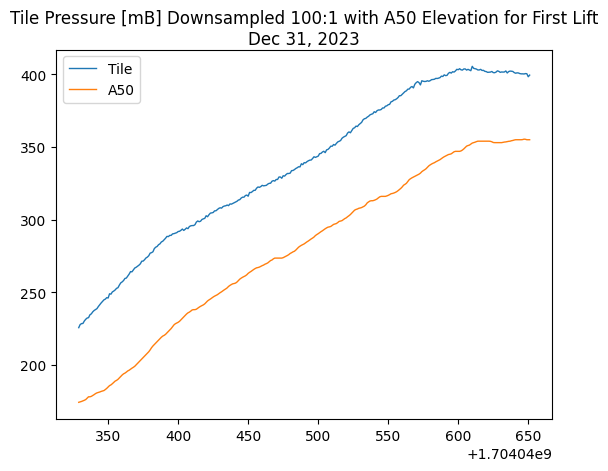

In [3]:
# find the first lift track for the a50
[a.__printProps__() for a in a50_all[0:5]]
lift1_a50 = a50_all[2]

# align the time axis of the tile to the a50
ts_tile = 24000
t = lift1_a50.time
tile_a = tile.raw_alt[ts_tile : (ts_tile + len(t) * 100) : 100] # downsampled to 1Hz

plt.rc('lines', linewidth=1)
fig, ax = plt.subplots()
ax.plot(t, tile_a, label='Tile')
ax.plot(t, lift1_a50.alt, label='A50')
ax.set_title('Tile Pressure [mB] Downsampled 100:1 with A50 Elevation for First Lift Dec 31, 2023', wrap=True)
ax.legend()
plt.show()

### Vertical Weather/Constant Offsets

Although ski activities are long, it's assumed that the weather won't drastically change thoughout tracking. Post processing, this is likely seen as the constant offset separating the a50 & tile altitude signals and can therefore be fixed by applying the correct constant offset.

Use the MAE to represent the offset separating these two signals:

In [4]:
import math as math

d = [abs(tile_a[i] - lift1_a50.alt[i]) for i in range(len(tile_a))]
avg_diff = math.fsum(d) / len(d)
print('avg offset', avg_diff, 'm')

avg offset 57.35953481321974 m


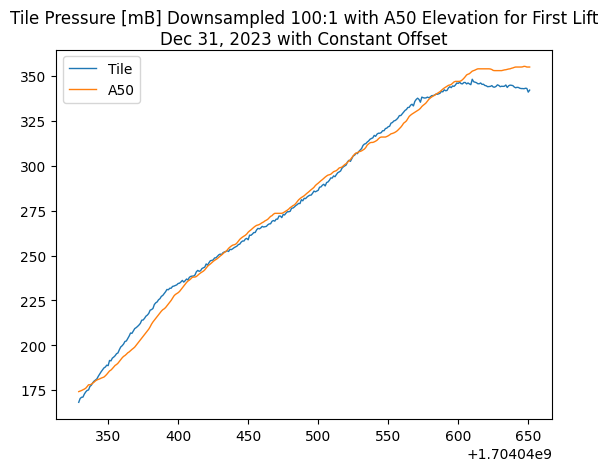

In [5]:
corrected_tile_a = [a - avg_diff for a in tile_a]

plt.rc('lines', linewidth=1)
fig, ax = plt.subplots()
ax.plot(t, corrected_tile_a, label='Tile')
ax.plot(t, lift1_a50.alt, label='A50')
ax.set_title('Tile Pressure [mB] Downsampled 100:1 with A50 Elevation for First Lift Dec 31, 2023 with Constant Offset', wrap=True)
ax.legend()
plt.show()

### Finding the Offsets of Best Fit with MAE

Since all ofsets were arbitrarily chosen, loop through both and report a MAE to discover the best offsets.

1. loop 1: iterate through horizontal time offsets
2. loop 2: calculate average vertical elevation offsets and apply
3. report a mae between the tile and static a50 elevation signals
4. 3d graph (topo, etc.) of the mae wrt time and elevation offsets
5. report the lowest

In [6]:
shift_h_tile = []
shift_v_tile = []

tile_plot = []

tile_ts = 19000

for i in range(200):
    # horizontal shift
    shift_h_tile = tile.raw_alt[tile_ts : (tile_ts + len(t) * 100) : 100]

    # reset the elevation starting point
    tile_el = 25

    for j in range(1000):
        # vertical shift
        shift_v_tile = [tile - tile_el for tile in shift_h_tile]

        # calculate the mae, sse
        d = [shift_v_tile[k] - lift1_a50.alt[k] for k in range(len(shift_v_tile))]
        abs_d = [abs(_d) for _d in d]
        d2 = [_d**2 for _d in d]
        mae = math.fsum(abs_d) / len(d)
        mse = math.fsum(d2) / len(d)

        # append to lists for plotting
        tile_plot.append([tile_ts, tile_el, mae, mse])

        # iterate
        tile_el += 0.05

    # iterate
    tile_ts += 100

In [7]:
ts_all = [m[0] for m in tile_plot]
el_all = [m[1] for m in tile_plot]
mae_all = [m[2] for m in tile_plot]
mse_all = [m[3] for m in tile_plot]

mae_min = min(mae_all)
mae_min_idx = mae_all.index(min(mae_all))
mae_min_ts = ts_all[mae_min_idx]
mae_min_el = el_all[mae_min_idx]

mse_min = min(mse_all)
mse_min_idx = mse_all.index(min(mse_all))
mse_min_ts = ts_all[mse_min_idx]
mse_min_el = el_all[mse_min_idx]

print('Lowest MAE:', mae_min)
print('\tat index:', mae_min_idx)
print('\ttime offset:', mae_min_ts, 'ms')
print('\televation offset:', mae_min_el, 'm')

print('Lowest MSE:', mse_min)
print('\tat index:', mse_min_idx)
print('\ttime offset:', mse_min_ts, 'ms')
print('\televation offset:', mse_min_el, 'm')

Lowest MAE: 2.494484475437896
	at index: 34472
	time offset: 22400 ms
	elevation offset: 48.599999999999156 m
Lowest MSE: 9.641379741619108
	at index: 35478
	time offset: 22500 ms
	elevation offset: 48.89999999999914 m


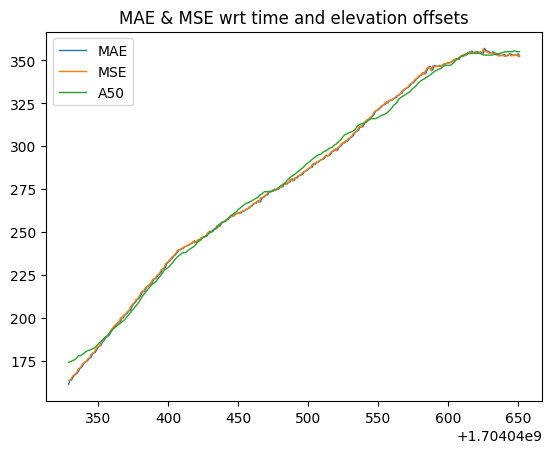

aligning global ts: 1704040329.0


In [8]:
mae_tile_a = tile.raw_alt[mae_min_ts : (mae_min_ts + len(t) * 100) : 100] # downsampled to 1Hz
mse_tile_a = tile.raw_alt[mse_min_ts : (mse_min_ts + len(t) * 100) : 100] # downsampled to 1Hz

mae_tile_a = [a - mae_min_el for a in mae_tile_a]
mse_tile_a = [a - mse_min_el for a in mse_tile_a]

plt.rc('lines', linewidth=1)
fig, ax = plt.subplots()
ax.plot(t, mae_tile_a, label='MAE')
ax.plot(t, mse_tile_a, label='MSE')
ax.plot(t, lift1_a50.alt, label='A50')
ax.set_title('MAE & MSE wrt time and elevation offsets', wrap=True)
ax.legend()
plt.show()

print('aligning global ts:', t[0])

### Optimal Time Offset

Aligning with the MAE, aligns the index of 22400 with a global timestamp of *1704040329* seconds. This places the first index of the tile data 22.4s before, at 1704040306.6 seconds, **1704040307** seconds with rounding.

The optimal altitude offset was computed to be 48.6m.

#### But...

Why stop at just the first lift data? See if you can stitch together the a50 ground truth elevation signals between all the tracks and align the entire tile pressure data to it!

### Stitching the Entire Elevation Data

In [9]:
stitched_a50_time = []
stitched_a50_dist = []
stitched_a50_vel = []
stitched_a50_alt = []

for track in a50_all: 
    stitched_a50_time += track.time
    stitched_a50_dist += track.dist
    stitched_a50_vel += track.vel
    stitched_a50_alt += track.alt

print(len(stitched_a50_time), 'a50 samples')
print(len(tile.raw_alt), 'tile samples')

14451 a50 samples
1446198 tile samples


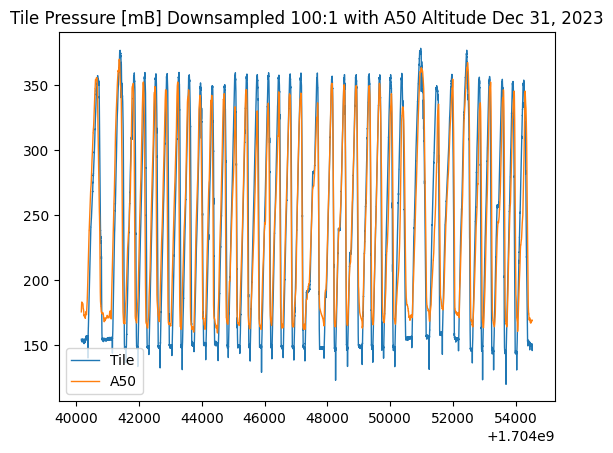

In [10]:
alt_correction = 48.6

# downsample the tile altitude signal to 1Hz
tile_a = tile.raw_alt[0 : len(tile.time) * 100 : 100]

# cut the end of the tile signal to the same length as the a50
tile_a = tile_a[:len(stitched_a50_time)]

# apply vertical offset
corrected_tile_a = [a - alt_correction for a in tile_a]

plt.rc('lines', linewidth=1)
fig, ax = plt.subplots()
ax.plot(stitched_a50_time, corrected_tile_a, label='Tile')
ax.plot(stitched_a50_time, stitched_a50_alt, label='A50')
ax.set_title('Tile Pressure [mB] Downsampled 100:1 with A50 Altitude Dec 31, 2023', wrap=True)
ax.legend()
plt.show()

### Calculating the Offsets from the Entire Dataset

Following the exact same procedure as before with the first lift. 

In [11]:
shift_h_tile = []
shift_v_tile = []

tile_plot = []

# zero now since we're looking at the whole skiing activity stitched togather.
# don't need to offset to the start of the lift track
tile_ts = 0

for i in range(30):
    # horizontal shift
    shift_h_tile = tile.raw_alt[tile_ts : (tile_ts + len(stitched_a50_time) * 100) : 100]

    # reset the elevation starting point
    tile_el = 35

    for j in range(500):
        # vertical shift
        shift_v_tile = [tile - tile_el for tile in shift_h_tile]

        # calculate the mae, sse
        d = [shift_v_tile[k] - stitched_a50_alt[k] for k in range(len(shift_v_tile))]
        abs_d = [abs(_d) for _d in d]
        d2 = [_d**2 for _d in d]
        mae = math.fsum(abs_d) / len(d)
        mse = math.fsum(d2) / len(d)

        # append to lists for plotting
        tile_plot.append([tile_ts, tile_el, mae, mse])

        # iterate
        tile_el += 0.05

    # iterate
    tile_ts += 100
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [12]:
ts_all = [m[0] for m in tile_plot]
el_all = [m[1] for m in tile_plot]
mae_all = [m[2] for m in tile_plot]
mse_all = [m[3] for m in tile_plot]

mae_min = min(mae_all)
mae_min_idx = mae_all.index(min(mae_all))
mae_min_ts = ts_all[mae_min_idx]
mae_min_el = el_all[mae_min_idx]

mse_min = min(mse_all)
mse_min_idx = mse_all.index(min(mse_all))
mse_min_ts = ts_all[mse_min_idx]
mse_min_el = el_all[mse_min_idx]

print('Lowest MAE:', mae_min)
print('\tat iteration:', mae_min_idx)
print('\ttime offset:', mae_min_ts)
print('\televation offset:', mae_min_el, 'm')

print('Lowest MSE:', mse_min)
print('\tat iteration:', mse_min_idx)
print('\ttime offset:', mse_min_ts)
print('\televation offset:', mse_min_el, 'm')

Lowest MAE: 26.448966465712413
	at iteration: 650
	time offset: 100
	elevation offset: 42.499999999999574 m
Lowest MSE: 1312.8314609794854
	at iteration: 1755
	time offset: 300
	elevation offset: 47.749999999999275 m


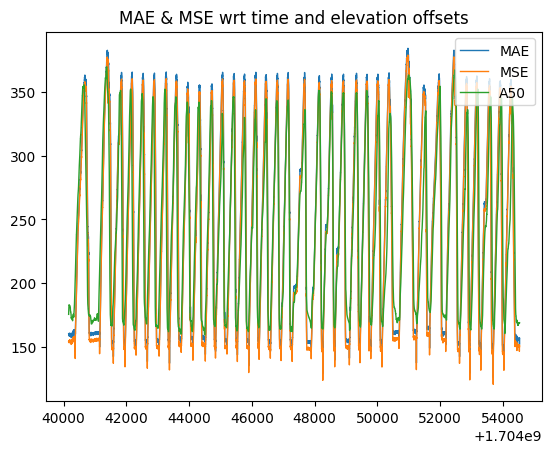

In [13]:
mae_tile_a = tile.raw_alt[mae_min_ts : mae_min_ts + len(tile.time) * 100 : 100] # downsampled to 1Hz
mse_tile_a = tile.raw_alt[mse_min_ts : mse_min_ts + len(tile.time) * 100 : 100] # downsampled to 1Hz

# cut the end off all the signals with the smallest offset
stitched_a50_time = stitched_a50_time[:min(len(stitched_a50_time), len(mae_tile_a), len(mse_tile_a))]
stitched_a50_alt = stitched_a50_alt[:min(len(stitched_a50_time), len(mae_tile_a), len(mse_tile_a))]
mae_tile_a = mae_tile_a[:min(len(stitched_a50_time), len(mae_tile_a), len(mse_tile_a))]
mse_tile_a = mse_tile_a[:min(len(stitched_a50_time), len(mae_tile_a), len(mse_tile_a))]

mae_tile_a = [a - mae_min_el for a in mae_tile_a]
mse_tile_a = [a - mse_min_el for a in mse_tile_a]

plt.rc('lines', linewidth=1)
fig, ax = plt.subplots()
ax.plot(stitched_a50_time, mae_tile_a, label='MAE')
ax.plot(stitched_a50_time, mse_tile_a, label='MSE')
ax.plot(stitched_a50_time, stitched_a50_alt, label='A50')
ax.set_title('MAE & MSE wrt time and elevation offsets', wrap=True)
ax.legend()
plt.show()

### Attempting the Function Method `syncTile()`

This method should create a attach global timestamps and corrected altitude data all at once:

In [14]:
from sync import syncTile

tile_sync = syncTile(
    tile=tile,
    truth=a50_all,
    alt_step=0.25,
    min_alt_start=42,
    max_alt_search=46)

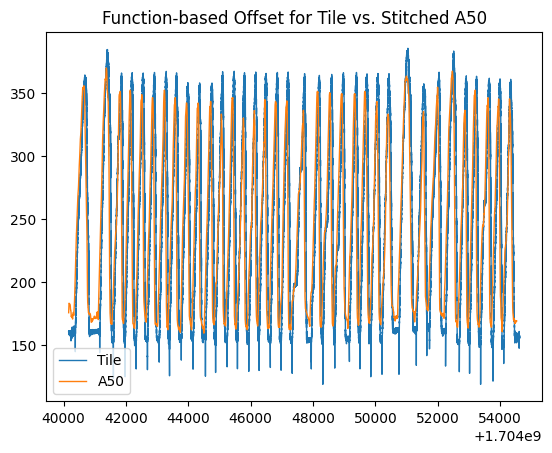

In [15]:
plt.rc('lines', linewidth=1)
fig, ax = plt.subplots()
ax.plot(tile_sync.time, tile_sync.alt, label='Tile')
ax.plot(stitched_a50_time, stitched_a50_alt, label='A50')
ax.set_title('Function-based Offset for Tile vs. Stitched A50', wrap=True)
ax.legend()
plt.show()